<a href="https://colab.research.google.com/github/SalvatoreDL01/EsempioClassificazioneGis/blob/main/EsempioColaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codice per ottenimoento immagini georeferenziate classificate



Il codice sottostante permette la creazione di immagini classificate. I file .tif utilizzati sono stati inseriti all'interno della cartella "materials".

Questo codice è stato creato su Google Colab e i dati sono stati salvati all'interno di Google Drive, per cui i percorsi delle risorse all'interno del codice faranno riferimento al MyDrive.

Nel caso si voglia utilizzare, testare o modificare questo codice si consiglia di porre la cartella "materials" all'interno del vostro MyDrive o di modificare i path delle risorse.

1. Packages da installare:

In [1]:
pip install seaborn

In [2]:
pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
pip install pandas

In [4]:
pip install fiona

In [5]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 62.6 MB/s eta 0:00:00


In [6]:
pip install geopandas

2. Inizializziamo i moduli e gli oggetti necessari:

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import geopandas as gpd
import fiona
import pandas as pd

# Libreria di classificazione
import sklearn
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Per il plotting
import seaborn as sns

sns.set(font_scale=1.5, style="whitegrid")

Costruiamo una lista dove sono contenuti tutti gli ID delle classi presenti all'interno della provincia di Salerno secondo la collezione "Copernicus CORINE Land Cover":

In [8]:
class_type = [
"0","1","2","3","4","5","6","9","10","11","12","14","15","16","17","18","19","20","21","22","23","24","25","27","28","29","30","31","32","29","40","43"
]

Inseriamo i percorsi dove trovare e salvare le risorse:

Modificarli in caso di necessità

In [9]:
path_class = "./drive/MyDrive/materials/raster/classi(SA).tif"
path_land = "./drive/MyDrive/materials/raster/Land(SA).tif"
path_land_classified = "./drive/MyDrive/materials/raster/LandClassificata(SA).tif"
path_points = "./drive/MyDrive/materials/point/PointsSA.shp"
path_points_temp = "./drive/MyDrive/materials/temporal/PointsSATemp.shp"

3. Aprimo l'immagine provvista di etichette (all'interno della banda 13) per ottenere una costellazione di punti su cui allenare i classificatori:

In [10]:
with rio.open(path_land_classified) as img:
    bands = (img.read()).shape[0]
print("Numero bande dell'immagine provvista di etichette: ", bands)
features = []

# Associamo dei nomi alle bande dell'immagine
for i in range(bands):
    features.append('band'+str(i+1))

# Stampiamo i nomi delle bande.
# Sarà utile per poter accedere e gestire il DataFrame
print('Nomi delle bande: ', features)
f_len = len(features)

Numero bande dell'immagine provvista di etichette:  13
Nomi delle bande:  ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10', 'band11', 'band12', 'band13']


4. Leggiamo i punti dalla costellazione costruita per  allenare i classificatori:

In [11]:
# Leggiamo i punti dal file PointsSA.shp
points = gpd.read_file(path_points)
# aggiungiamo una collonna 'id'
points = points.assign(id=range(len(points)))
# salviamo il nuovo file di punti a cui è stato aggiunto l'id
points.to_file(path_points_temp)
# convertiamo il GeoDataFrame in un Pandas DataFrame e rimuoviamo le geometrie
points_df = pd.DataFrame(points.drop(columns='geometry'))

5. Organizziamo il DataFrame di Pandas:

In [12]:
sampled = pd.Series()

# Leggiamo in nuovo SHP di punti con fiona e iteriamo per ogni feature
with fiona.open(path_points_temp) as shp:
    for feature in shp:
        siteID = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        # Leggiamo i valori di ogni pixel ad ogni coordinata con Rasterio
        with rio.open(path_land_classified) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Aggiorniamo la Pandas Serie
        sampled.loc[siteID] = value

# Riorganiziamo i dati del DataFrame e li stampiamo
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(),
                   columns=features)
df1['id'] = df1.index

data = pd.merge(df1, points_df, on ='id')
print('Sampled Data: \n',data)

<ipython-input-12-6e058e9b9e22>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sampled = pd.Series()


Sampled Data: 
         band1   band2   band3   band4   band5   band6   band7   band8   band9  \
0      0.0273  0.0244  0.0517  0.0668  0.0978  0.1646  0.1853  0.2263  0.3075   
1      0.0398  0.0147  0.0464  0.0114  0.0951  0.3828  0.4763  0.4963  0.4287   
2      0.0207  0.0415  0.0643  0.0605  0.1052  0.2865  0.3605  0.3668  0.4287   
3      0.0142  0.0244  0.0563  0.0290  0.0996  0.2782  0.3234  0.3548  0.3667   
4      0.0354  0.0372  0.0668  0.0636  0.1240  0.2544  0.3058  0.3003  0.3333   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
99995  0.0200  0.0402  0.0722  0.0688  0.1237  0.2260  0.2605  0.2701  0.3269   
99996  0.0108  0.0054  0.0250  0.0239  0.0668  0.1722  0.2058  0.1934  0.3381   
99997  0.0452  0.0618  0.0938  0.1121  0.1465  0.2129  0.2475  0.2597  0.3045   
99998  0.0503  0.0325  0.0585  0.0930  0.1213  0.1556  0.1783  0.2021  0.1773   
99999  0.0103  0.0216  0.0489  0.0299  0.0934  0.2662  0.3308  0.3437  0.3584   

       band

6. Costruiamo e splittiamo il training set dal validation set:
Lo slpit è di 70% dei punti nel training e 30% nel validation.

In [13]:
x = data.iloc[:,0:f_len-1]
X = x.values
#print(X)
y = data.iloc[:,-2]
Y = y.values
#print(Y)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (70000, 12)
X_test Shape: (30000, 12)
y_train Shape: (70000,)
y_test Shape:(30000,)


7. Costruiamo i classificatori:

Classificatore a Support Vector Machine

In [14]:
from sklearn.svm import SVC

clfSVM = SVC(kernel='linear')
clfSVM.fit(X_train, y_train)

clfSVM_pred = clfSVM.predict(X_test)

#Stampiamo le metriche di valutazione
print(f"Accuracy SVM: {accuracy_score(y_test, clfSVM_pred)*100}")
print(classification_report(y_test, clfSVM_pred))


Accuracy SVM: 44.14
              precision    recall  f1-score   support

         0.0       0.54      0.22      0.31       311
         1.0       0.00      0.00      0.00       802
         2.0       0.00      0.00      0.00       178
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         5
         6.0       0.00      0.00      0.00        29
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         7
        11.0       0.29      0.50      0.37      3252
        12.0       0.00      0.00      0.00       181
        14.0       0.00      0.00      0.00        21
        15.0       0.00      0.00      0.00       467
        16.0       0.22      0.13      0.16      2622
        17.0       0.00      0.00      0.00       282
        18.0       0.00      0.00      0.00       437
        19.0       0.20      0.22      0.21      2980
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classificatore ad Albero decisionale

In [15]:
from sklearn.tree import DecisionTreeClassifier

clfTree = DecisionTreeClassifier().fit(X_train, y_train)
clfTree_pred = clfTree.predict(X_test)

print(f"Accuracy Decision Tree: {accuracy_score(y_test, clfTree_pred)*100}")
print(classification_report(y_test, clfTree_pred))


Accuracy Decision Tree: 37.75666666666667
              precision    recall  f1-score   support

         0.0       0.40      0.41      0.40       311
         1.0       0.19      0.20      0.20       802
         2.0       0.16      0.15      0.15       178
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         5
         6.0       0.03      0.03      0.03        29
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         7
        11.0       0.35      0.34      0.35      3252
        12.0       0.16      0.17      0.16       181
        14.0       0.00      0.00      0.00        21
        15.0       0.08      0.09      0.09       467
        16.0       0.25      0.25      0.25      2622
        17.0       0.06      0.06      0.06       282
        18.0       0.07      0.07      0.07       437
        19.0       0.19      0.19      

Classificatore ad Gradient Boosting

In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier

clfGB = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)

clfGB_pred = clfGB.predict(X_test)

print(f"Accuracy Gradient Boosting: {accuracy_score(y_test, clfGB_pred)*100}")
print(classification_report(y_test, clfGB_pred))

Accuracy Gradient Boosting: 44.690000000000005
              precision    recall  f1-score   support

         0.0       0.46      0.31      0.37       311
         1.0       0.31      0.16      0.21       802
         2.0       0.12      0.09      0.10       178
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         5
         6.0       0.01      0.03      0.01        29
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         7
        11.0       0.39      0.43      0.41      3252
        12.0       0.22      0.14      0.17       181
        14.0       0.00      0.00      0.00        21
        15.0       0.08      0.02      0.03       467
        16.0       0.30      0.20      0.24      2622
        17.0       0.12      0.04      0.06       282
        18.0       0.00      0.00      0.00       437
        19.0       0.25      0.18 

Classificatore Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB

clfGNB = GaussianNB().fit(X_train, y_train)

clfGNB_pred = clfGNB.predict(X_test)

print(f"Accuracy Naive Bayes: {accuracy_score(y_test, clfGNB_pred)*100}")
print(classification_report(y_test, clfGNB_pred))

Accuracy Naive Bayes: 37.093333333333334
              precision    recall  f1-score   support

         0.0       0.19      0.25      0.22       311
         1.0       0.16      0.23      0.19       802
         2.0       0.12      0.12      0.12       178
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         5
         6.0       0.00      0.00      0.00        29
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         7
        11.0       0.36      0.03      0.05      3252
        12.0       0.04      0.02      0.02       181
        14.0       0.01      0.05      0.01        21
        15.0       0.00      0.00      0.00       467
        16.0       0.18      0.39      0.25      2622
        17.0       0.00      0.00      0.00       282
        18.0       0.06      0.01      0.01       437
        19.0       0.22      0.07      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classificatore Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

clfRF = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

clfRF_pred = clfRF.predict(X_test)

print(f"Accuracy Random Forest: {accuracy_score(y_test, clfRF_pred)*100}")
print(classification_report(y_test, clfRF_pred))

Accuracy Random Forest: 50.39666666666667
              precision    recall  f1-score   support

         0.0       0.58      0.38      0.46       311
         1.0       0.29      0.22      0.25       802
         2.0       0.43      0.15      0.22       178
         3.0       0.00      0.00      0.00        10
         4.0       0.00      0.00      0.00         3
         5.0       0.00      0.00      0.00         5
         6.0       1.00      0.03      0.07        29
         9.0       0.00      0.00      0.00         2
        10.0       0.00      0.00      0.00         7
        11.0       0.42      0.58      0.49      3252
        12.0       0.55      0.12      0.20       181
        14.0       0.00      0.00      0.00        21
        15.0       0.52      0.05      0.09       467
        16.0       0.32      0.40      0.36      2622
        17.0       0.42      0.05      0.09       282
        18.0       0.75      0.03      0.07       437
        19.0       0.25      0.27      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8: Definiamo una funzione che ci permette di costruire, salvare e stampare la matrice di confusione dei classificatori:

In [19]:
# Confusion Matrix:
#                   cName rappresenta il nome del classificaore;
#                   clf_pred è la predizione fatta sui punti;
#                   y_test l'oracolo
def makeMatrix(cName,clf_pred,y_test):
  cm = confusion_matrix(y_test, clf_pred)
  print('Confusion Matrix RF: \n',cm)
  cm_percent = cm/np.sum(cm)

  # Plottiamo la matrice
  plt.figure(figsize=(43, 43), facecolor='w', edgecolor='k')
  sns.set(font_scale=1.5)

  sns.heatmap(cm_percent,
            xticklabels=class_type,
            yticklabels=class_type,
            cmap="YlGn",
            annot=True,
            fmt='.2%',
            cbar=False,
            linewidths=2,
            linecolor='black')

  plt.title(cName)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')

  # Salviamo la matrice. Questo path potrebbe dover essere modificato
  plt.savefig(f'./drive/MyDrive/materials/figs/confusion_matrix_{cName}.png', dpi=300, bbox_inches='tight')

9. Costruiamo e salviamo le matrice di confuisione:

Matrice di confusione di classificatore a SVM

Confusion Matrix RF: 
 [[68  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 [ 1  0  0 ...  0  0  0]
 ...
 [ 2  0  0 ...  0  0  0]
 [ 9  0  0 ...  0  0  0]
 [11  0  0 ...  0  0  0]]


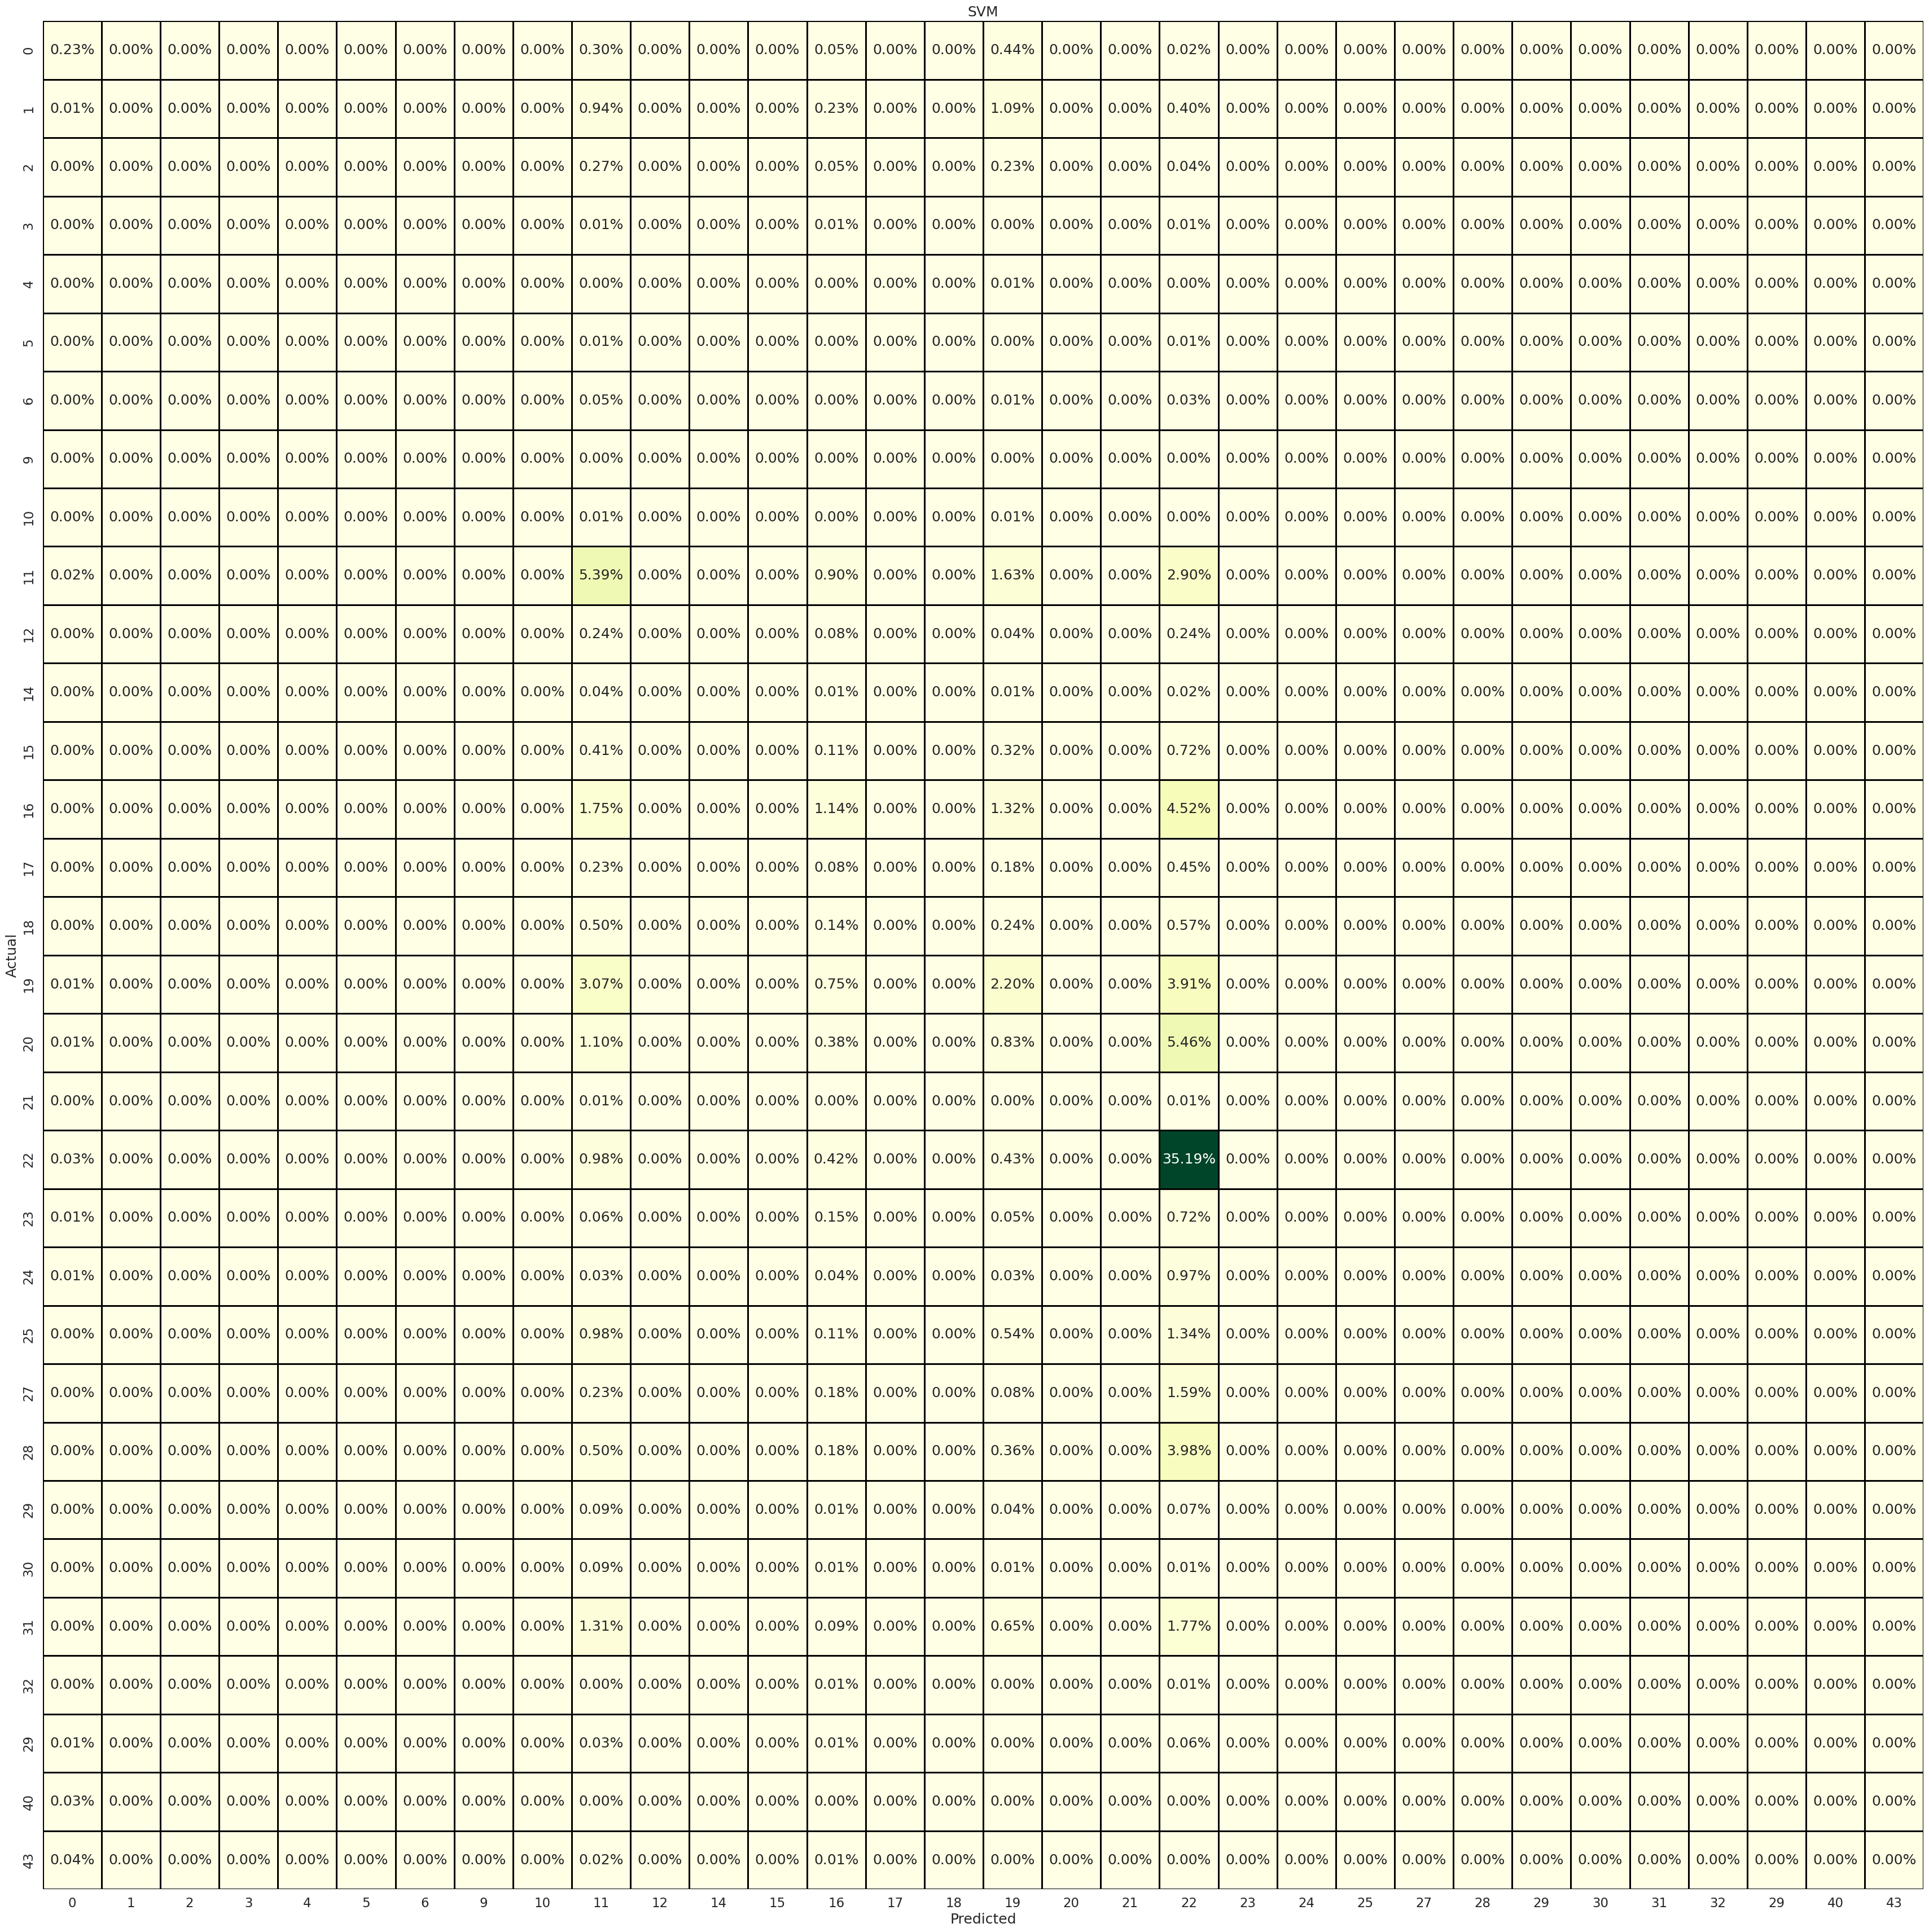

In [20]:
makeMatrix("SVM",clfSVM_pred,y_test)

Matrice di confusione di Classificatore ad albero decisionale

Confusion Matrix RF: 
 [[126  57  16 ...   0   1   2]
 [ 47 160  18 ...   1   0   6]
 [ 21  28  26 ...   0   0   0]
 ...
 [  1   2   0 ...   2   0   0]
 [  1   1   0 ...   0   9   0]
 [  3   3   1 ...   1   2   0]]


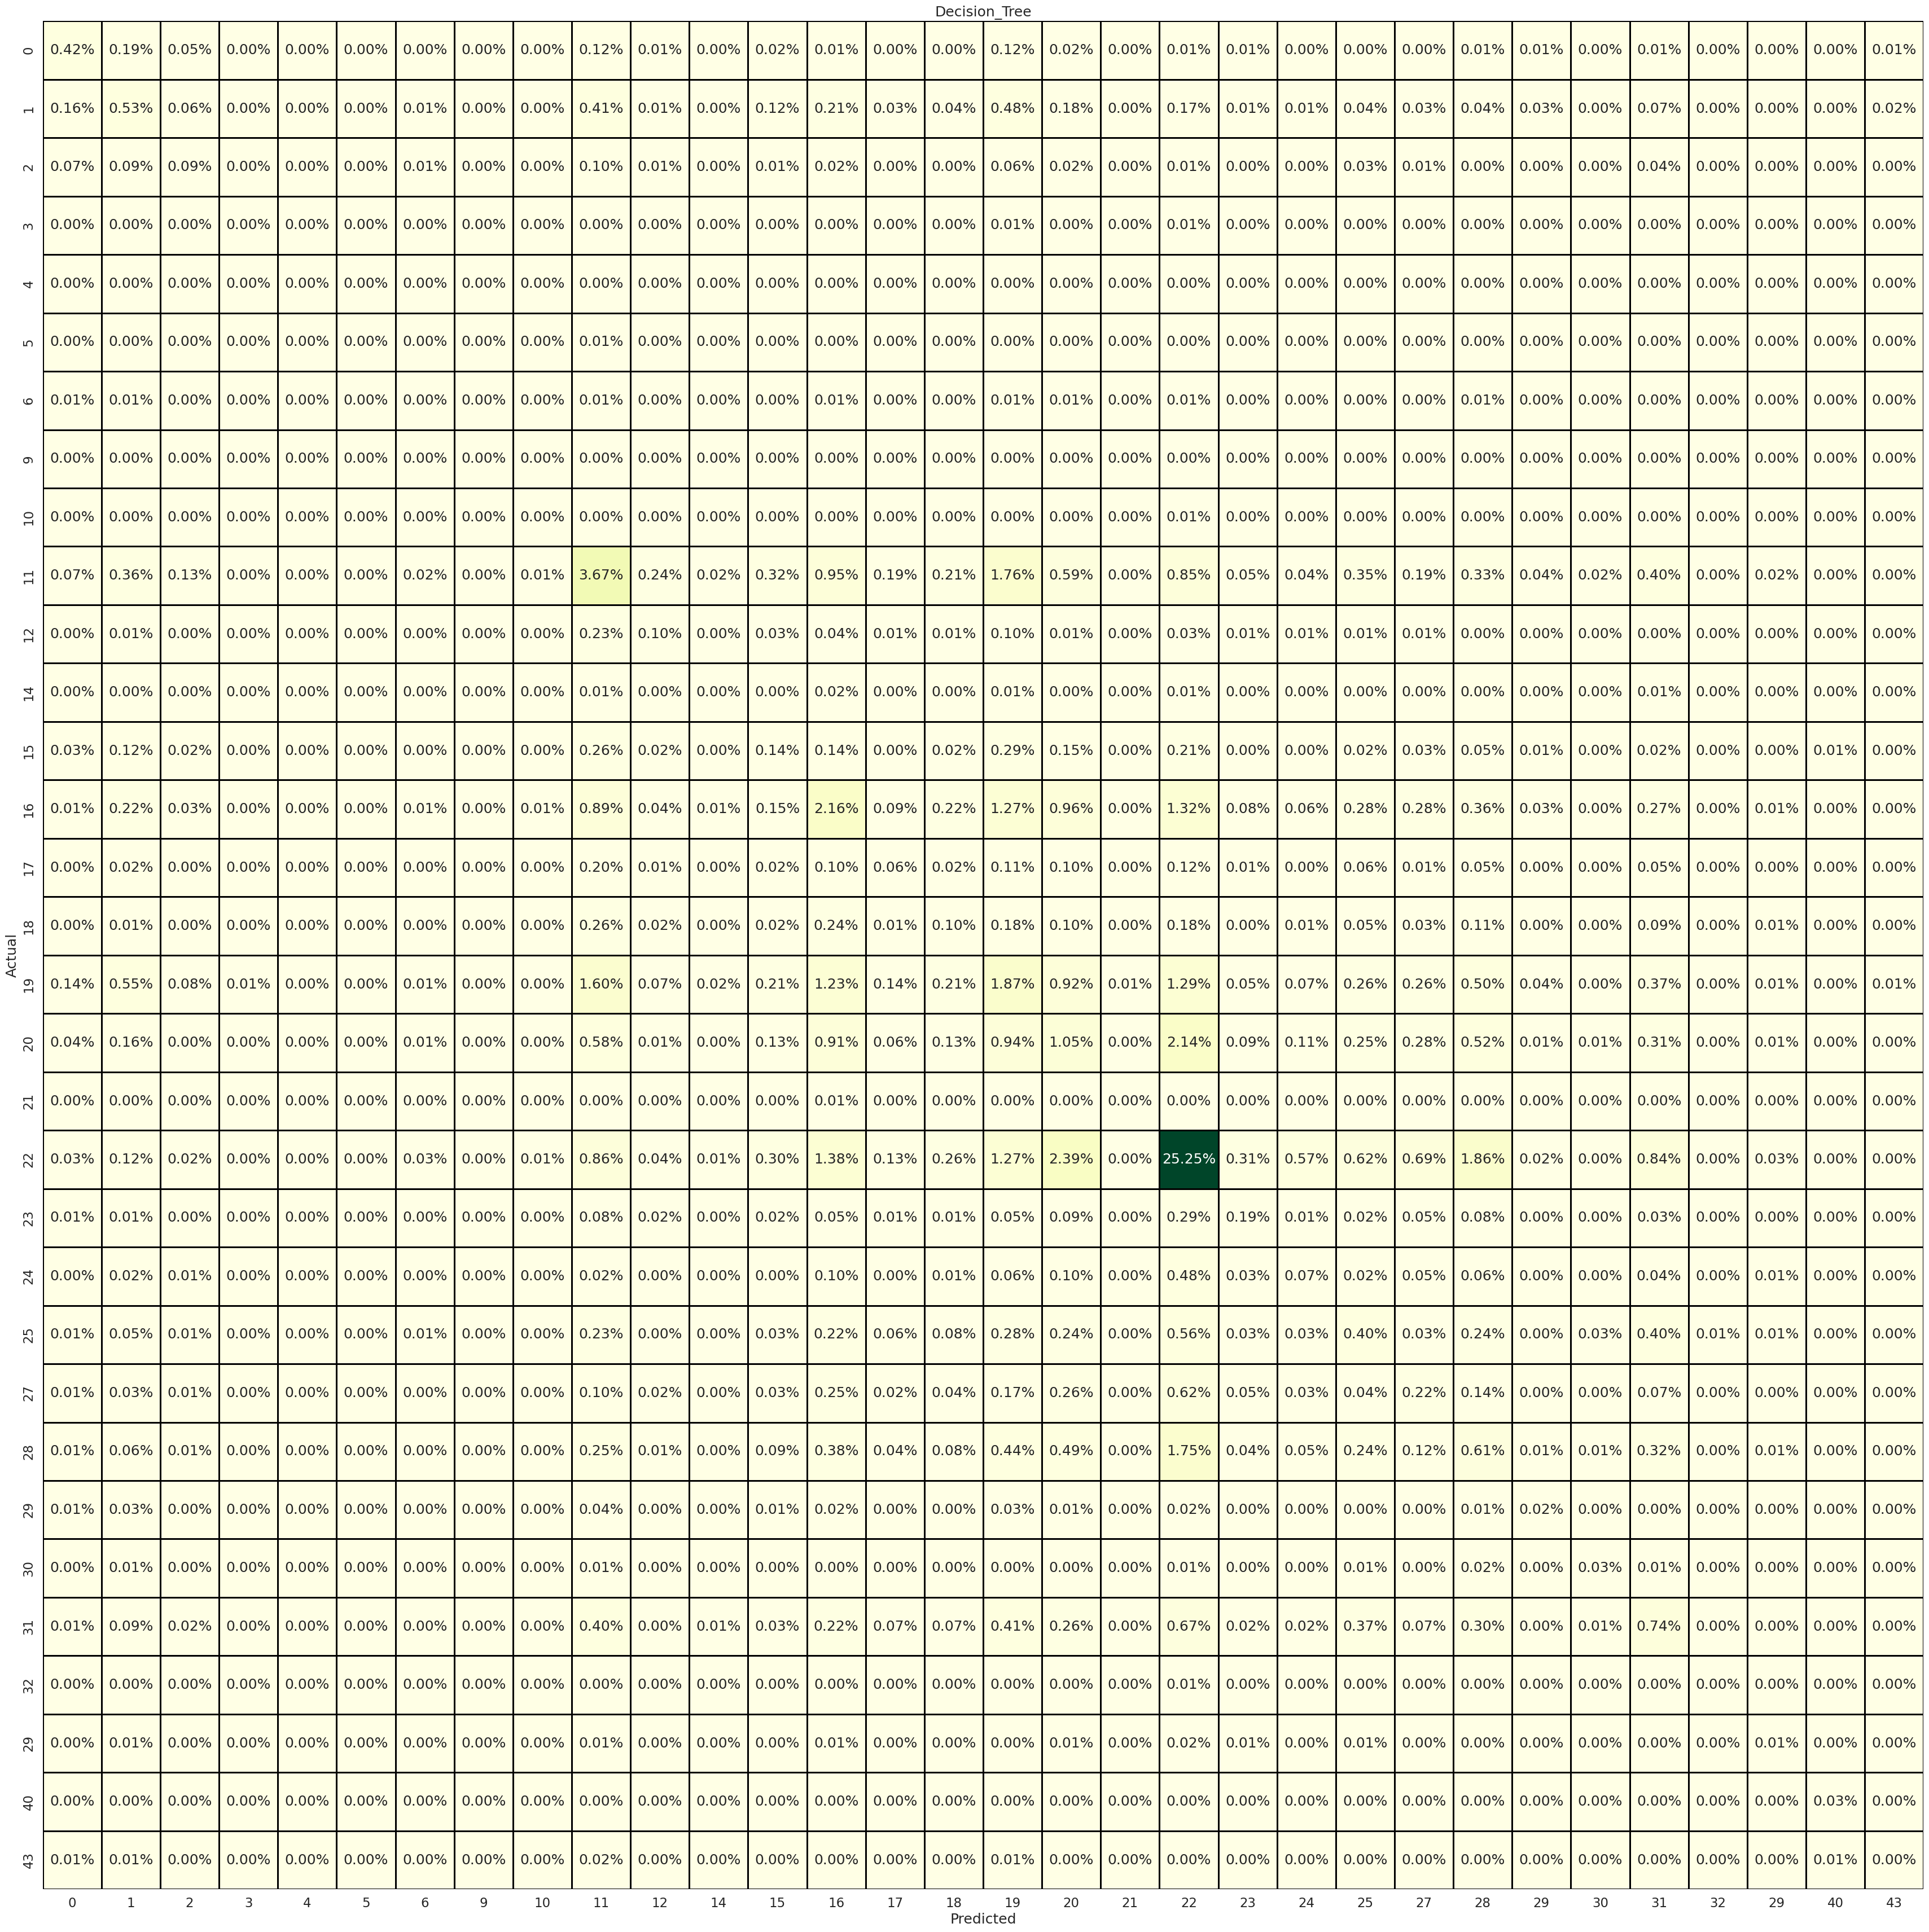

In [21]:
makeMatrix("Decision_Tree",clfTree_pred,y_test)

Matrice di confusione di Classificatore a Gradient Boosting

Confusion Matrix RF: 
 [[ 95  58  17 ...   5   0   4]
 [ 24 128  25 ...   8   1   9]
 [ 13  12  16 ...   2   0   4]
 ...
 [  2   0   0 ...   0   0   0]
 [  0   0   0 ...   1   0   0]
 [  0   4   1 ...   4   0   0]]


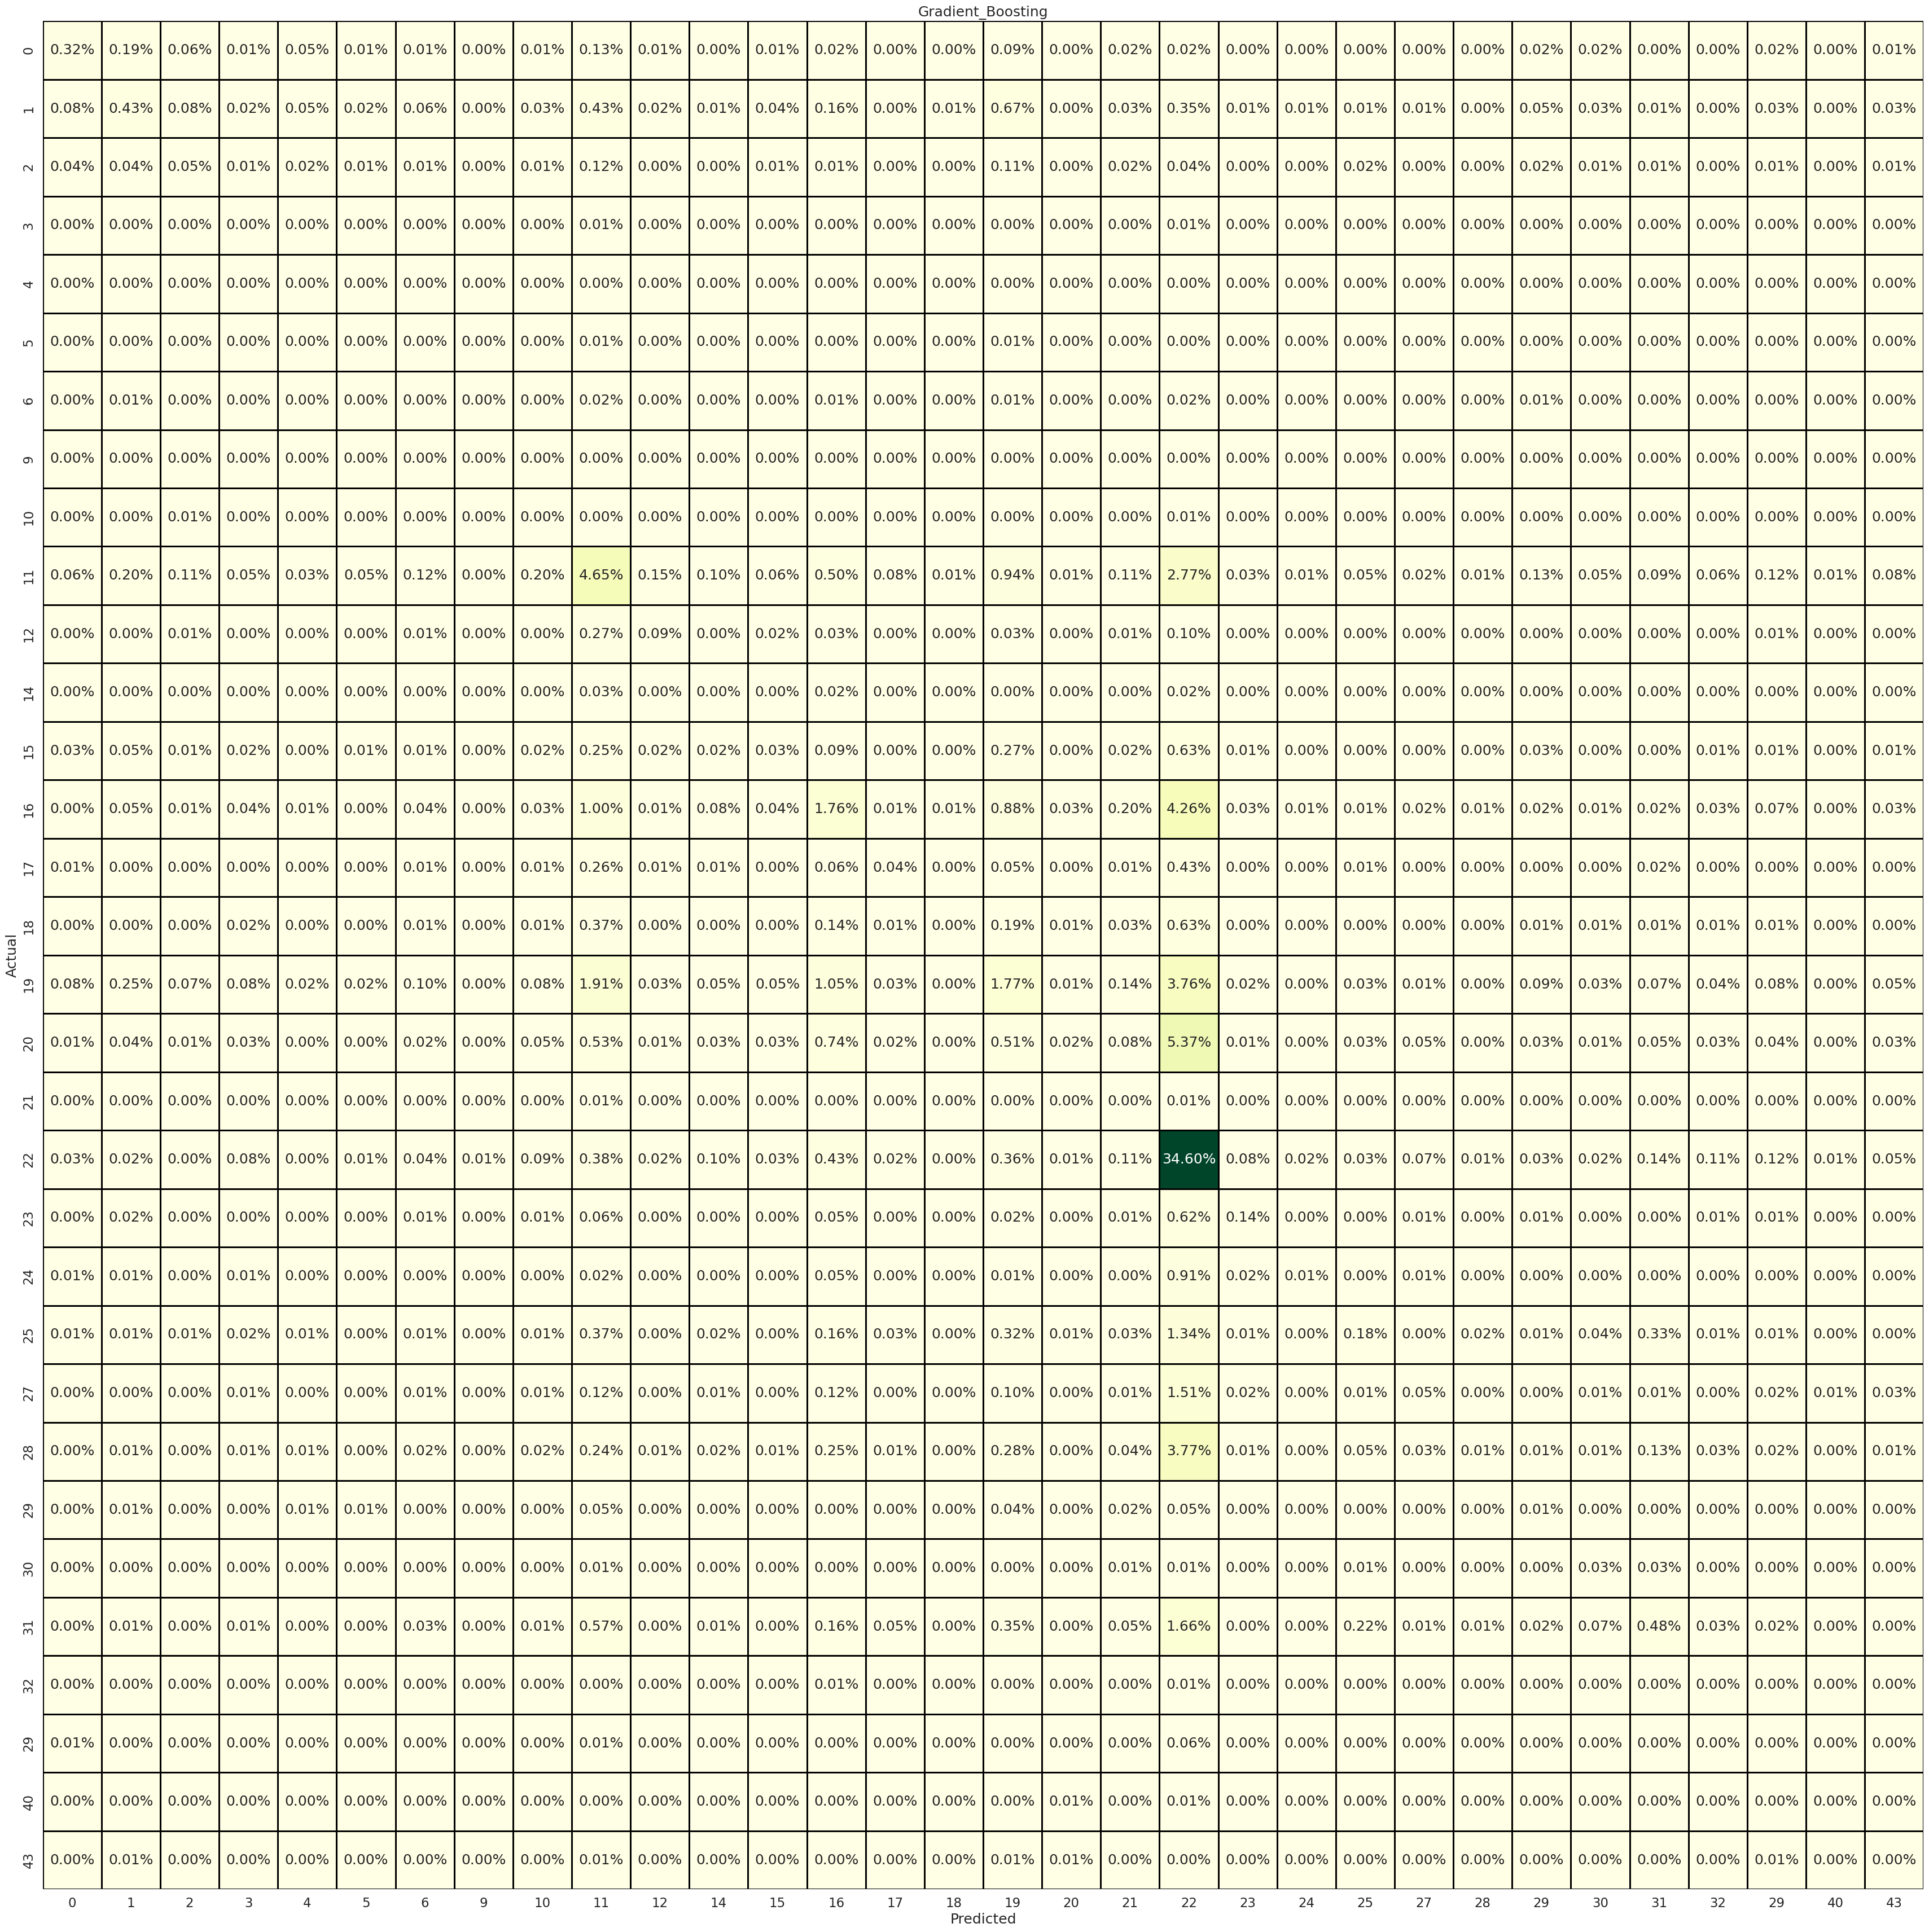

In [22]:
makeMatrix("Gradient_Boosting",clfGB_pred,y_test)

Matrice di confusione di Classificatore Naive Bayes

Confusion Matrix RF: 
 [[ 79 131  10 ...   0   3   1]
 [ 19 183  23 ...   0   2   1]
 [  8  47  21 ...   0   3   0]
 ...
 [  1   0   0 ...   0   3   0]
 [  0   0   0 ...   0   9   0]
 [  5   2   0 ...   0   8   1]]


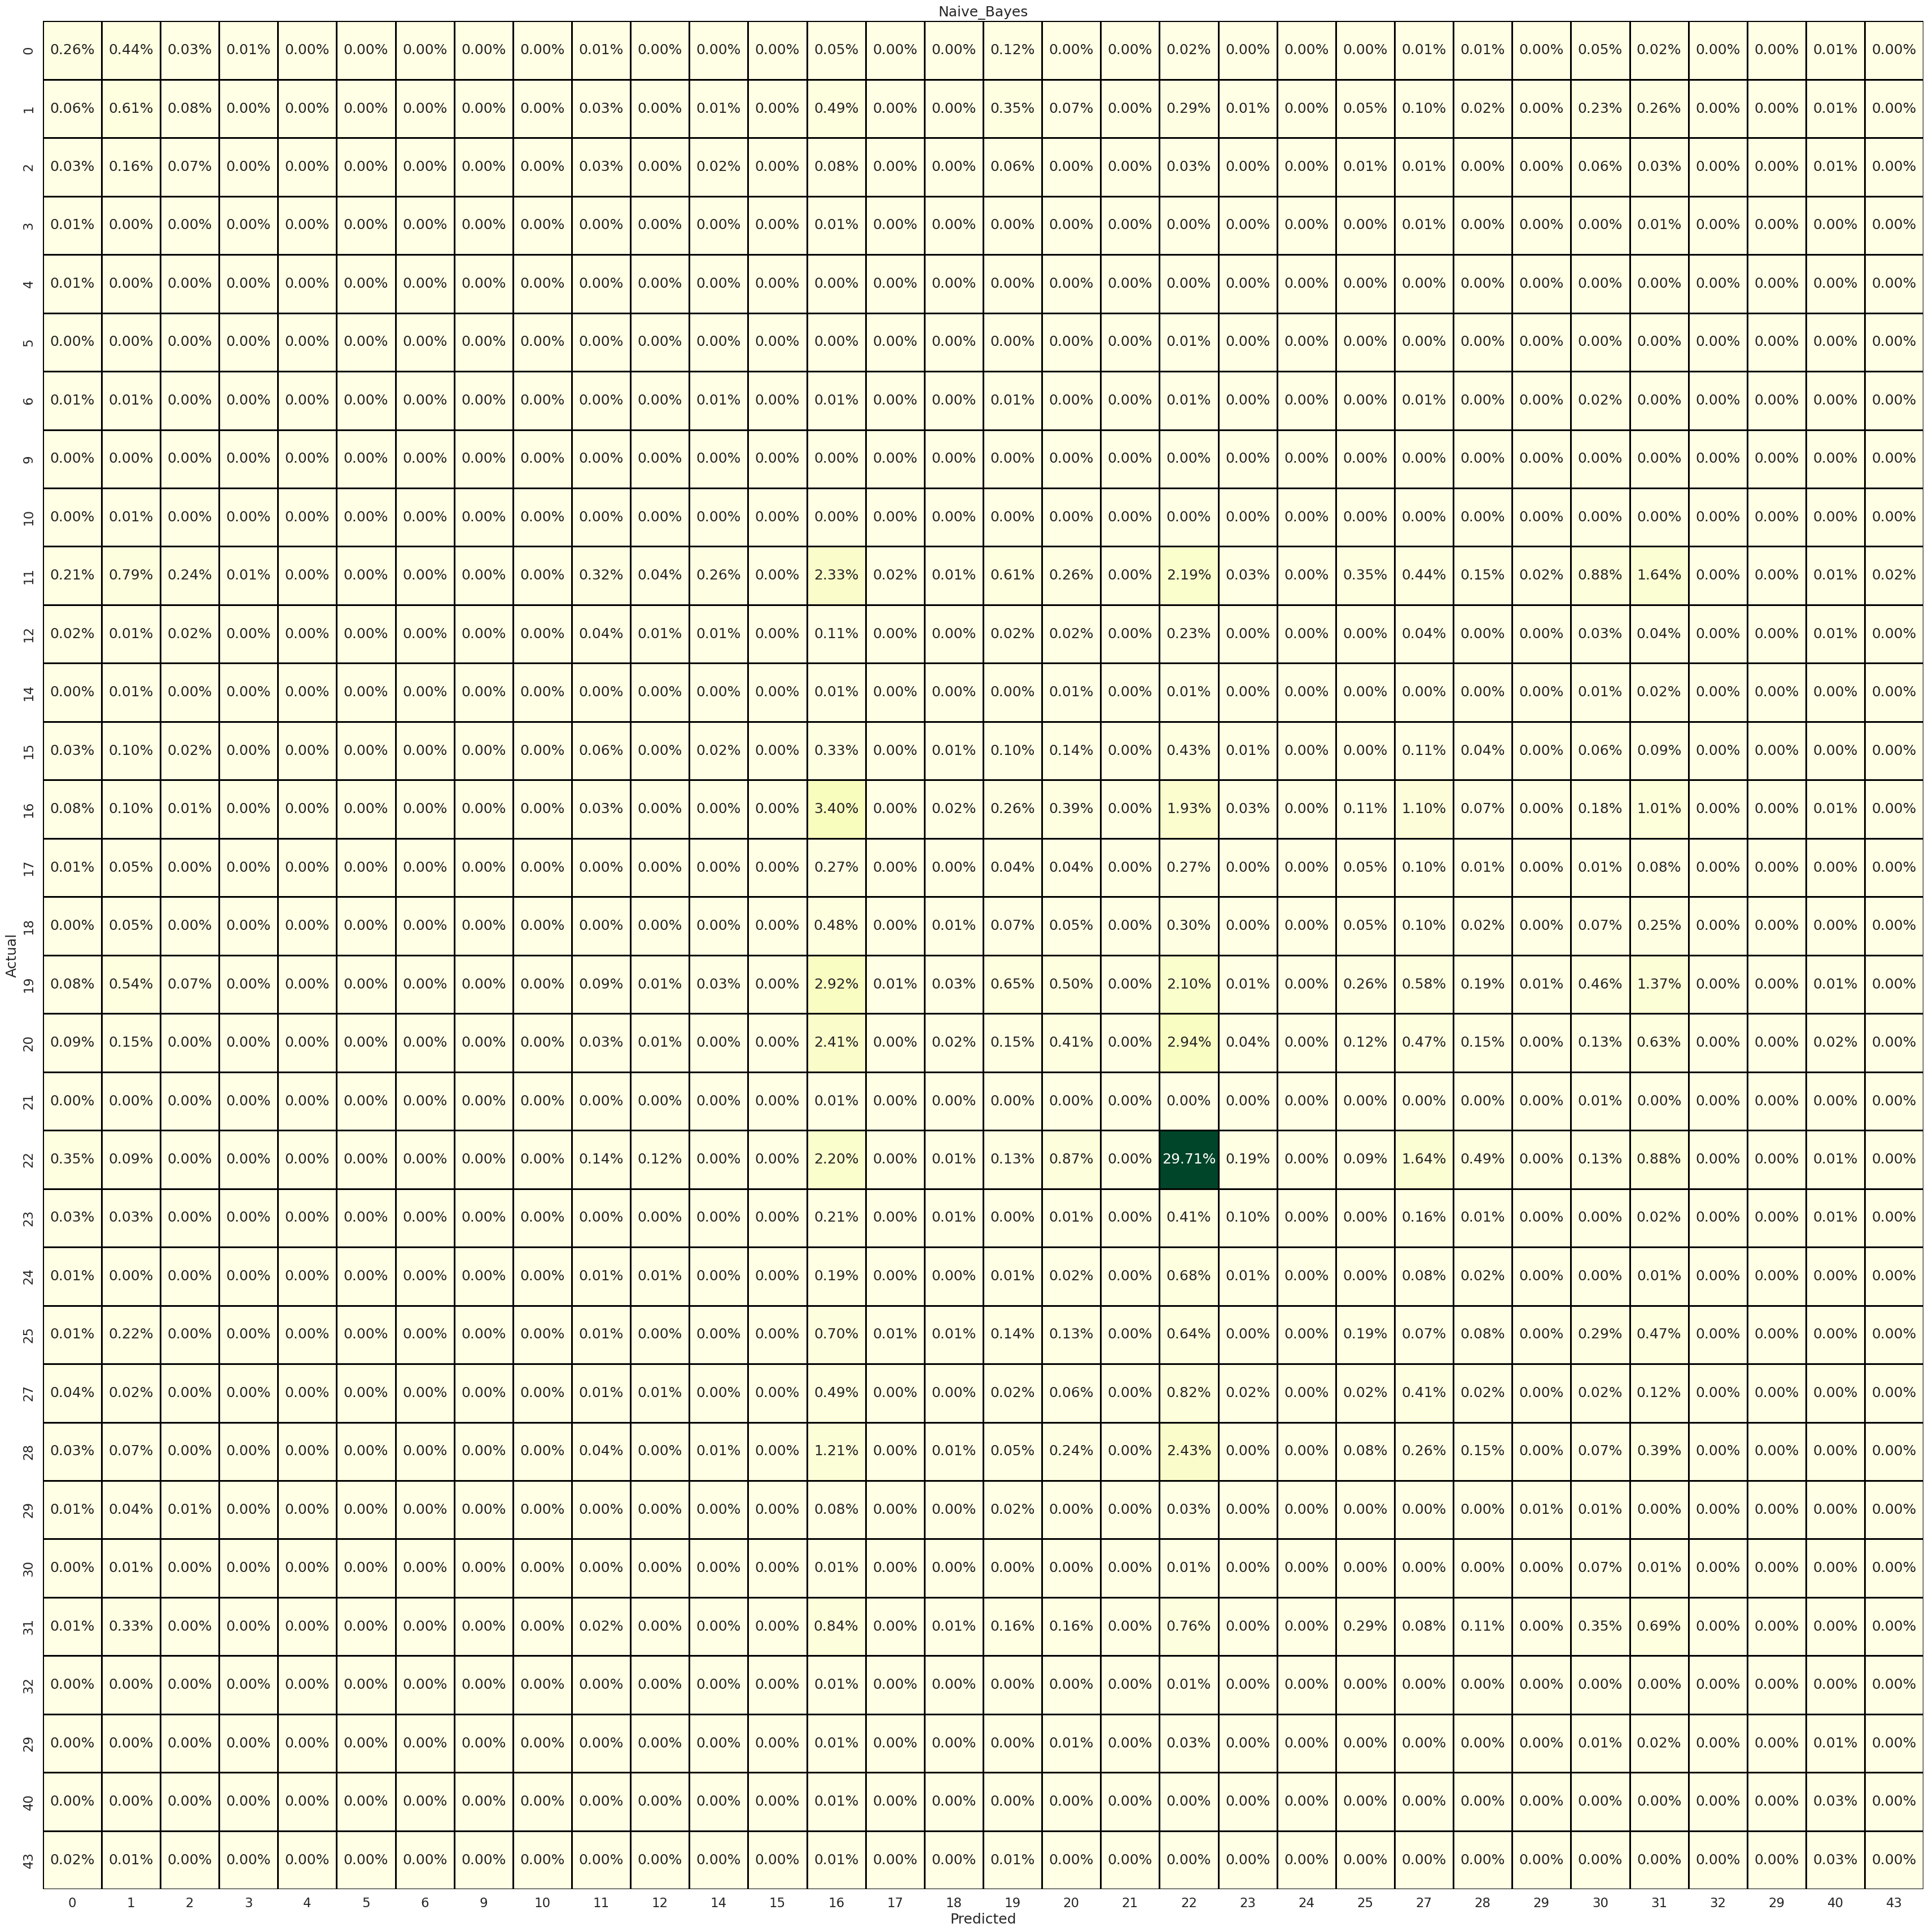

In [23]:
makeMatrix("Naive_Bayes",clfGNB_pred,y_test)

Matrice di confusione di Classificatore Random Forest

Confusion Matrix RF: 
 [[117  92   5 ...   0   0   0]
 [ 25 175   9 ...   0   0   0]
 [ 15  31  27 ...   0   0   0]
 ...
 [  0   0   0 ...   3   1   0]
 [  0   0   0 ...   0   9   0]
 [  7   3   1 ...   0   0   1]]


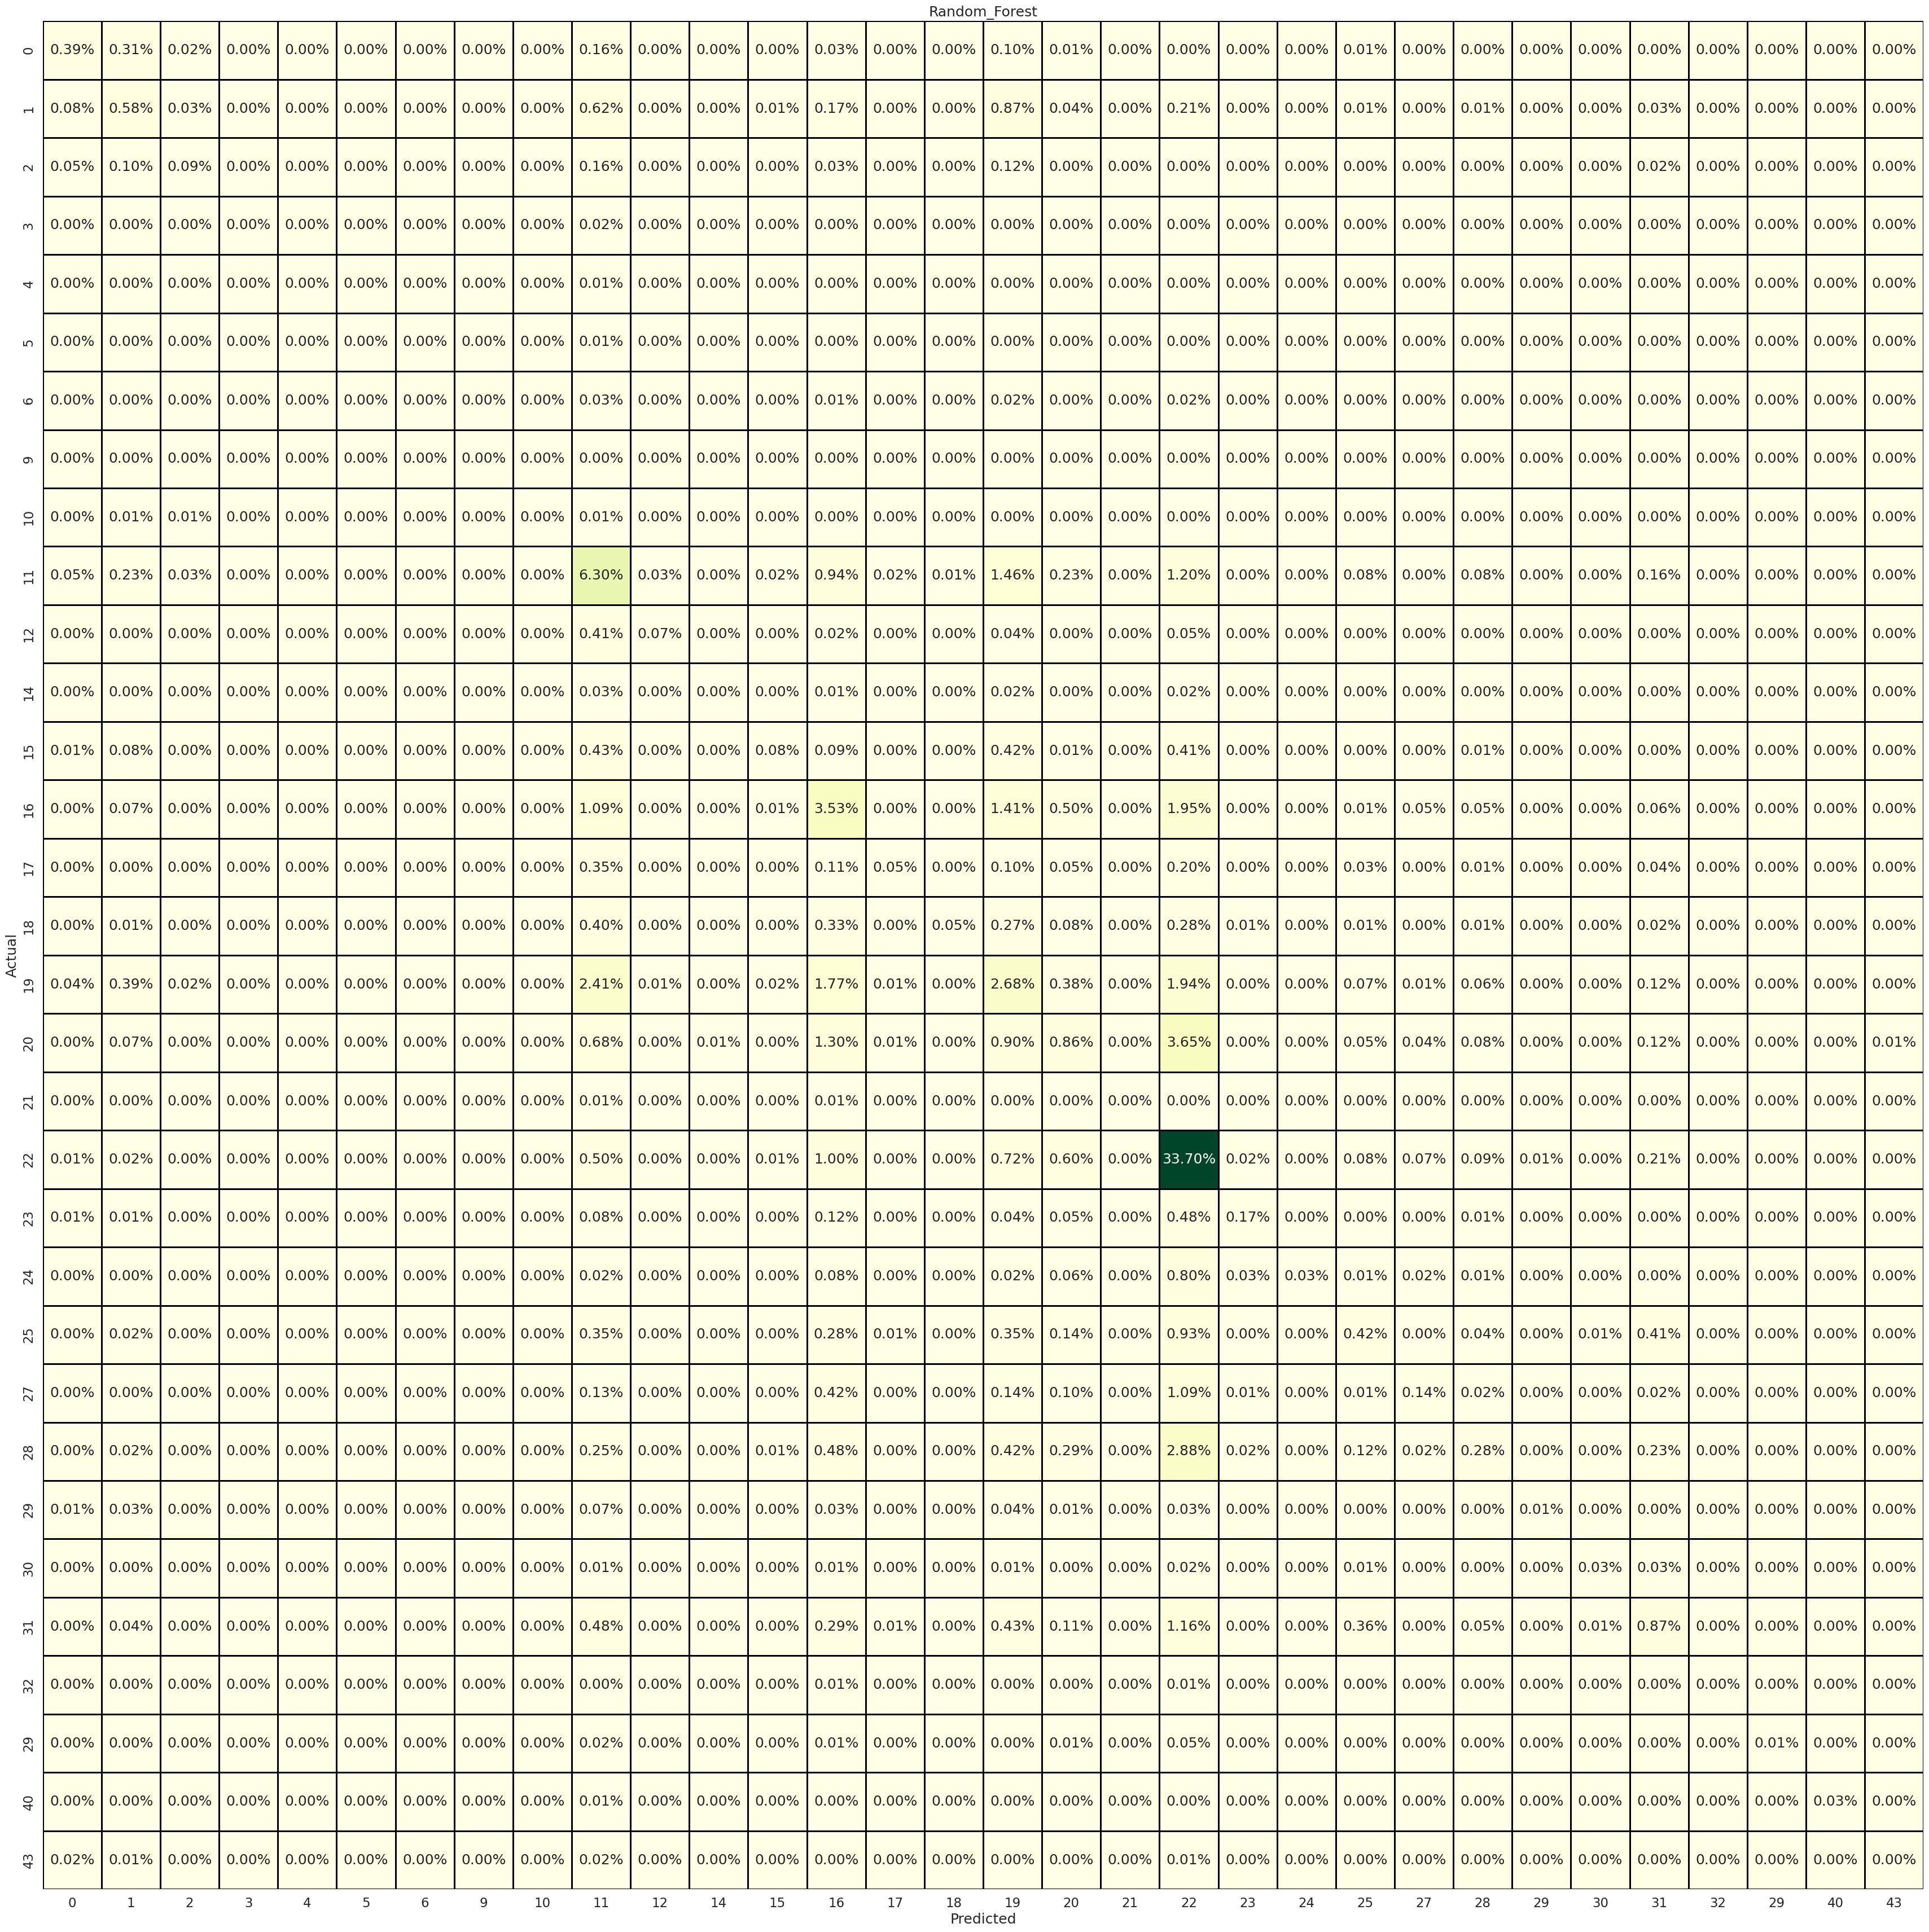

In [24]:
makeMatrix("Random_Forest",clfRF_pred,y_test)

10. Apriamo l'immagine da classificare e otteniamo parametri come altezza e larghezza:

In [25]:
img = rio.open(path_land)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len-1)
print('Ridemensioniamo i dati per la predizione: ',img_n.shape)
metadata = img.meta

crs = metadata.get("crs")
transform = metadata.get("transform")
print(transform)
height = metadata.get("height")
width = metadata.get("width")


Height: 686
Width: 743
Bands: 12

Ridemensioniamo i dati per la predizione:  (509698, 12)
| 0.00, 0.00, 14.79|
| 0.00,-0.00, 40.81|
| 0.00, 0.00, 1.00|


11. Costruiamo una funzione per classificare e salvare le immagini classificate:
Modificare il path se necessario

In [26]:
def save_Raster(cName,clf,img_n,height,width,crs,transform):
  pred_full = clf.predict(img_n)

  print('Prediction Done, now exporting raster \n')

  img_reshape = pred_full.reshape(height, width)

  path_export = f"./drive/MyDrive/materials/Results/{cName}Result.tif"

  out_raster = rio.open(path_export,'w+',
                                            crs = crs,
                                            transform = transform,
                                            driver='GTiff',
                                            height=height,
                                            width=width,
                                            count=1,
                                            dtype='uint8',
                                            nodata = 255
                                            )

  out_raster.write(img_reshape, 1)
  out_raster.close()

12. Classifichiamo e salviamo le immagini:

Classifica SVM

In [27]:
save_Raster("SVM",clfSVM,img_n,height,width,crs,transform)

Prediction Done, now exporting raster 



Classifica ad Albero Decisionale

In [28]:
save_Raster("Decision_Tree",clfTree,img_n,height,width,crs,transform)

Prediction Done, now exporting raster 



Classifica Gradient Boosting

In [29]:
save_Raster("Gradient_Boosting",clfGB,img_n,height,width,crs,transform)

Prediction Done, now exporting raster 



Classifica Naive Bayes

In [30]:
save_Raster("Naive_Bayes",clfGNB,img_n,height,width,crs,transform)

Prediction Done, now exporting raster 



Classifica Random Forest

In [31]:
save_Raster("Random_Forest",clfRF,img_n,height,width,crs,transform)

Prediction Done, now exporting raster 

